# Description
This notebook prepares the plot of an independent variable posterior.

To illustrate multimodality, it exaggerates the degree of freedom of the biomass calibration model.

In [1]:
import numpy
from matplotlib import cm, pyplot
import pandas

import calibr8

import models
import plotting

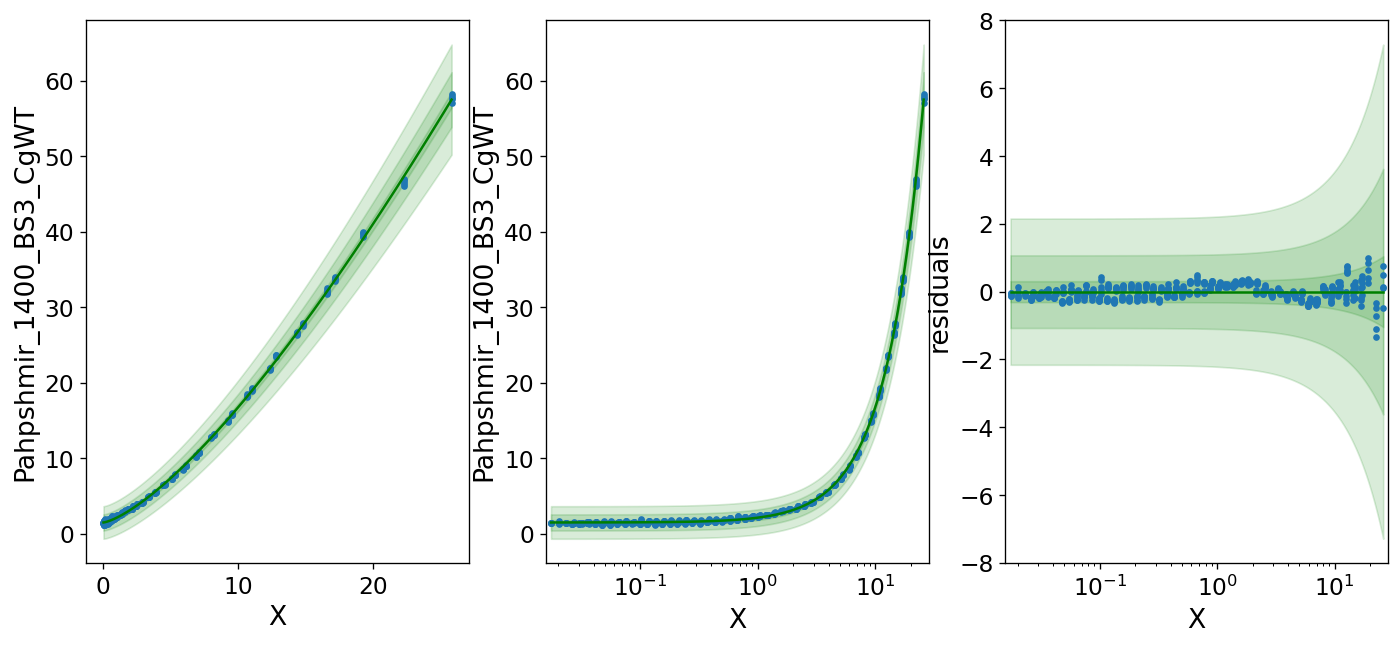

In [2]:
cm_biomass = models.get_biomass_model()
theta_manual = list(cm_biomass.theta_fitted)
theta_manual[-1] = 1
cm_biomass.theta_fitted = tuple(theta_manual)
calibr8.plot_model(cm_biomass);

<class 'calibr8.core.NumericPosterior'>
    ETI (95.0 %): [0.3747, 1.388] Δ=1.0133
    HDI (95.0 %): [0.3948, 1.4051] Δ=1.0103


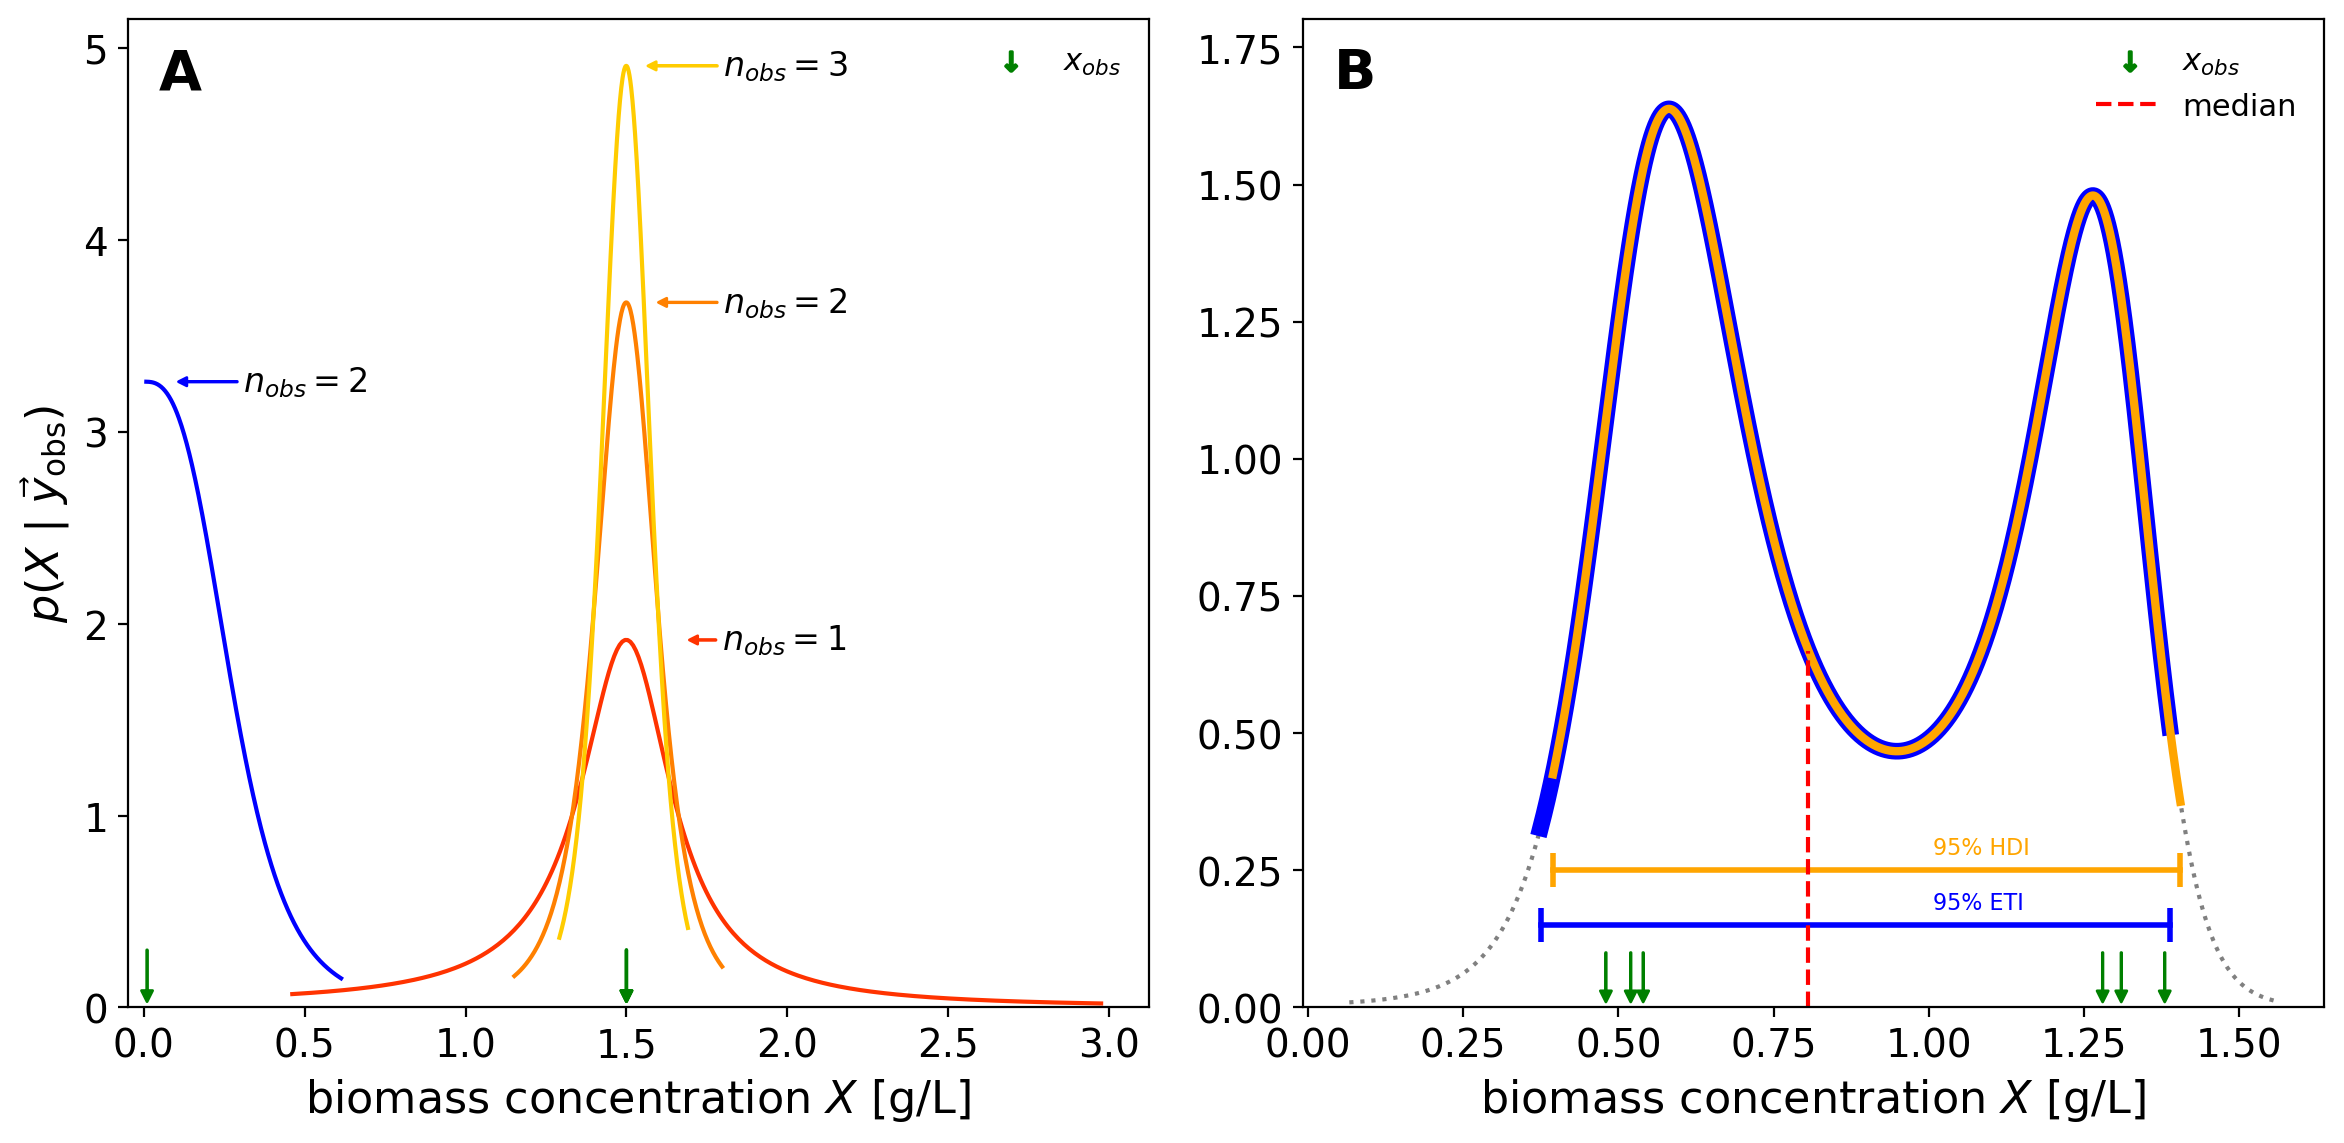

In [3]:
def plot_multimodality(ax, x_obs, a, b, steps=1000, ci_prob=0.95):
    model = cm_biomass
    y_obs = cm_biomass.predict_dependent(x_obs)[0]

    pst_full = model.infer_independent(
        y_obs, lower=a, upper=b, steps=steps, ci_prob=0.999
    )
    pst = model.infer_independent(y_obs, lower=a, upper=b, steps=steps, ci_prob=ci_prob)
    print(pst)

    # ETI
    y = 0.15
    ax.plot(pst_full.eti_x, pst_full.eti_pdf, color="gray", linestyle=":")
    ax.plot(pst.eti_x, pst.eti_pdf, color="blue", linewidth=6)
    ax.plot(
        [pst.eti_lower, pst.eti_upper],
        [y] * 2,
        marker="|",
        markersize=12,
        markeredgewidth=2,
        linestyle="-",
        color="blue",
        linewidth=2,
    )
    ax.text(
        pst.median + 0.2,
        y + 0.03,
        f"{round(pst.eti_prob, 2)*100:.0f}% ETI",
        color="blue",
        fontsize=8,
    )
    # HDI
    y = 0.25
    ax.plot(pst.hdi_x, pst.hdi_pdf, color="orange", linewidth=3)
    ax.plot(
        [pst.hdi_lower, pst.hdi_upper],
        [y] * 2,
        marker="|",
        markersize=12,
        markeredgewidth=2,
        linestyle="-",
        color="orange",
        linewidth=2,
    )
    ax.text(
        pst.median + 0.2,
        y + 0.03,
        f"{round(pst.hdi_prob, 2)*100:.0f}% HDI",
        color="orange",
        fontsize=8,
    )

    for x in x_obs:
        ax.annotate(
            "",
            xy=(x, 0.01),
            xytext=(x, 0.1),
            xycoords="data",
            arrowprops=dict(
                facecolor="green",
                edgecolor="green",
                width=0.2,
                headwidth=4,
                headlength=4,
            ),
            horizontalalignment="right",
            verticalalignment="top",
        )
    ax.legend(
        handles=[
            ax.scatter(
                [], [], color="green", marker=r"$\downarrow$", s=50, label="$x_{obs}$"
            ),
            ax.plot(
                [pst.median] * 2,
                [0, pst.eti_pdf[numpy.argmin(numpy.abs(pst.eti_x - pst.median))]],
                linestyle="--",
                label="median",
                color="red",
            )[0],
        ],
        frameon=False,
        loc="upper right",
    )
    ax.set_ylim(0, numpy.max(pst.eti_pdf) * 1.1)
    return fig, ax


fig, axs = pyplot.subplots(dpi=200, figsize=(12, 6), nrows=1, ncols=2)

# A: lower limit and different number of observations
scenarios = [
    # color, x_true, n_obs
    ("blue", 0.01, 2),
    (cm.autumn(0.2), 1.5, 1),
    (cm.autumn(0.5), 1.5, 2),
    (cm.autumn(0.8), 1.5, 3),
]
for color, x, n_obs in scenarios:
    x_obs = [x] * n_obs
    pst = cm_biomass.infer_independent(
        y=[
            *cm_biomass.predict_dependent(x_obs)[0],
        ],
        lower=0.0001,
        upper=20,
        ci_prob=0.95,
    )
    x_max = pst.eti_x[numpy.argmax(pst.eti_pdf)]
    y_max = pst.eti_pdf.max()
    axs[0].plot(
        pst.eti_x,
        pst.eti_pdf,
        color=color,
    )
    axs[0].annotate(
        "$n_{obs}=$" + str(n_obs),
        xy=(x_max + 0.2 / n_obs, y_max),
        xytext=(x_max + 0.3, y_max),
        arrowprops=dict(
            facecolor=color, edgecolor=color, width=0.2, headwidth=3, headlength=3
        ),
        fontsize=12,
        verticalalignment="center",
        horizontalalignment="left",
    )
    axs[0].annotate(
        "",
        xy=(x, 0.03),
        xytext=(x, 0.3),
        xycoords="data",
        arrowprops=dict(
            facecolor="green", edgecolor="green", width=0.2, headwidth=4, headlength=4
        ),
        horizontalalignment="right",
        verticalalignment="top",
    )
axs[0].legend(
    handles=[
        axs[0].scatter(
            [], [], color="green", marker=r"$\downarrow$", s=50, label="$x_{obs}$"
        ),
    ],
    frameon=False,
    loc="upper right",
)
axs[0].set_xlim(-0.05)
axs[0].set_ylim(0)

# B: Multimodality, ETI, HDI
cm_biomass.theta_fitted = tuple(theta_manual)
plot_multimodality(
    ax=axs[1],
    x_obs=[0.48, 0.52, 0.54] + [1.28, 1.31, 1.38],
    a=0.001,
    b=3,
    steps=100000,
    ci_prob=0.95,
)
axs[0].set_ylabel(r"$p(X\ |\ \vec{y}_\mathrm{obs})$")
axs[0].set_xlabel("biomass concentration $X$ [g/L]")
axs[1].set_xlabel("biomass concentration $X$ [g/L]")
axs[0].text(0.03, 0.93, "A", transform=axs[0].transAxes, size=20, weight="bold")
axs[1].text(0.03, 0.93, "B", transform=axs[1].transAxes, size=20, weight="bold")

fig.tight_layout()
plotting.savefig(fig, "4.1.3 UQ_infer_independent")
pyplot.show()

In [4]:
%load_ext watermark
%watermark

Last updated: 2021-05-10T19:18:13.271632+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

